<a href="https://colab.research.google.com/github/davidmertenjones/Thinkful_DSB_Unit_7/blob/master/MovieLens_Capstone_100k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MovieLens 100k - Recommender Systems

### Description (from README file):

u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code.
              The user ids are the ones used in the u.data data set.

## Module Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy import stats

from fastai.collab import *
from fastai.callbacks import *

import keras
from IPython.display import SVG
from keras.optimizers import adam 
from keras.utils.vis_utils import model_to_dot

import tensorflow as tf

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')
tf.logging.set_verbosity(tf.logging.ERROR)


Using TensorFlow backend.


In [0]:
path_string = '/content/drive/Colab Notebooks/ml-100k/{}'

## Mount Google Drive

In [0]:
try:
  genre = pd.read_csv(path_string.format('u.genre'), delimiter='|',
                    names=['genre', 'encoding'])
except FileNotFoundError:
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
  !apt-get update -qq 2>&1 > /dev/null
  !apt-get -y install -qq google-drive-ocamlfuse fuse


  from google.colab import auth
  auth.authenticate_user()
  from oauth2client.client import GoogleCredentials
  creds = GoogleCredentials.get_application_default()
  import getpass
  !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
  vcode = getpass.getpass()
  !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

  !mkdir -p drive
  !google-drive-ocamlfuse drive

In [4]:
!ls '/content/drive/Colab Notebooks/ml-100k/'

allbut.pl	      keras_model3.png	      u2.base  u5.test	u.info
df_supervised.csv     keras_network_bias.png  u2.test  ua.base	u.item
fai_gridsearch15.csv  mku.sh		      u3.base  ua.test	u.occupation
fai_gridsearch30.csv  README		      u3.test  ub.base	u.user
fai_gridsearch.csv    rfr_gridsearch.csv      u4.base  ub.test
keras_model1.png      u1.base		      u4.test  u.data
keras_model2.png      u1.test		      u5.base  u.genre


## Data Import

#### Genre

In [0]:
genre = pd.read_csv(path_string.format('u.genre'), delimiter='|',
                    names=['genre', 'encoding'])

In [6]:
genrelist = genre['genre'].values.tolist()
genrelist

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [0]:
itemcolumns = ['movieId', 'title', 'release',
               'vid_release', 'imdb_url'] + genrelist

#### Movies (with n-hot encoded genre)

In [0]:
# This is an older dataset, so it doesn't use UTF-8 encoding.

items = pd.read_csv(path_string.format('u.item'), delimiter='|',
                    names=itemcolumns,
                    encoding='latin-1')

items = items.drop(['vid_release', 'imdb_url'], 1)

In [9]:
items.head()

,movieId,title,release,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


#### Ratings (User-Movie pairs with rating)

In [0]:
ratings = pd.read_csv(path_string.format('u.data'), delimiter='\t',
                      names=['userId', 'movieId', 'rating', 'timestamp'])

In [11]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
ratings['rating'] = ratings['rating'].apply(lambda x: float(x))

# EDA

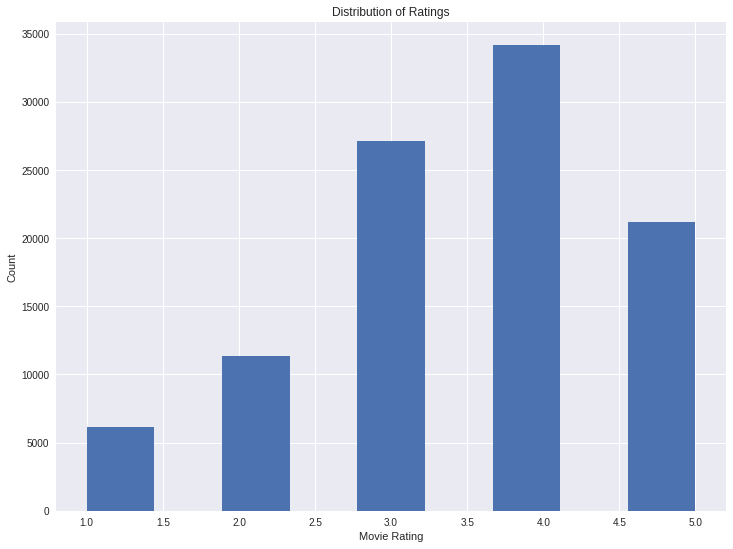

In [13]:
plt.rcParams['figure.figsize'] = 12, 9

plt.title('Distribution of Ratings')
plt.hist(ratings.rating, bins=9)
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.show()

In [14]:
ratings.rating.describe()

count    100000.000000
mean          3.529860
std           1.125674
min           1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

This distribution shows some left skewness. The mean movie rating (3.53) is higher than the central possible score (3.0) 

## Rating Counts and Means

In [0]:
# Function for Regression Plots showing R-squared value

def R_coeff(x, y):
    """Returns rounded Pearson R coefficient for two variables."""
    rcoeff = stats.pearsonr(x, y)
    return str(np.round(rcoeff[0], 4))

#### Users

In [16]:
# Get number of movies each user has reviewed.

user_rating_count = ratings.groupby('userId')['rating'].count()

user_rating_count = pd.DataFrame(user_rating_count).reset_index()
user_rating_count.rename(columns={'rating': 'user_count'}, inplace=True)

user_rating_count.head()


,userId,user_count
0,1,272
1,2,62
2,3,54
3,4,24
4,5,175


In [17]:
# Get mean rating user has given to all movies they have reviewed.

user_rating_mean = ratings.groupby('userId')['rating'].mean()

user_rating_mean = pd.DataFrame(user_rating_mean).reset_index()
user_rating_mean.rename(columns={'rating': 'user_mean'}, inplace=True)

user_rating_mean.head()

,userId,user_mean
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286


In [18]:
user_rating_stats = pd.merge(user_rating_count, user_rating_mean, on='userId')
user_rating_stats.head()

,userId,user_count,user_mean
0,1,272,3.610294
1,2,62,3.709677
2,3,54,2.796296
3,4,24,4.333333
4,5,175,2.874286


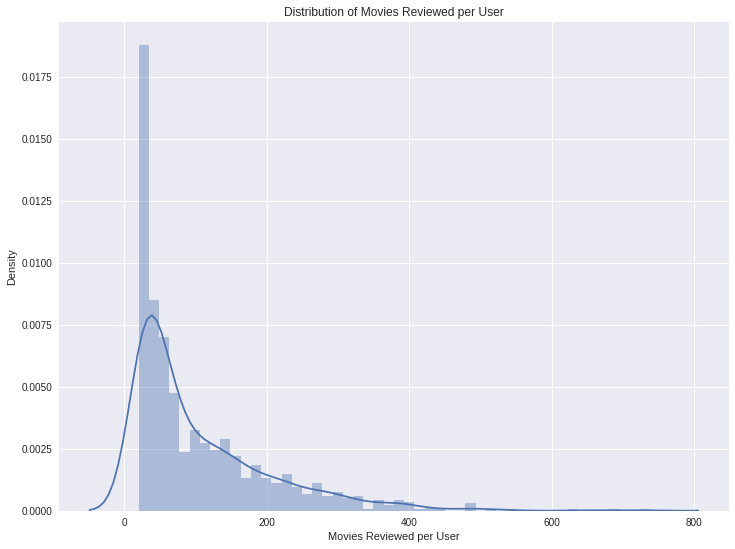

In [19]:
sns.distplot(user_rating_stats['user_count'], bins=50)
plt.title('Distribution of Movies Reviewed per User')
plt.xlabel('Movies Reviewed per User')
plt.ylabel('Density')
plt.show()

In [20]:
user_rating_stats['user_count'].describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: user_count, dtype: float64

In [21]:
user_rating_stats['user_count'].median()

65.0

Most of the users in the dataset have reviewed 100 or fewer films. The median is 65 films reviewed (roughly 3.9%). The user who has reviewed the most films still has only reviewed 737/1682 (43.8% of the films in the set).

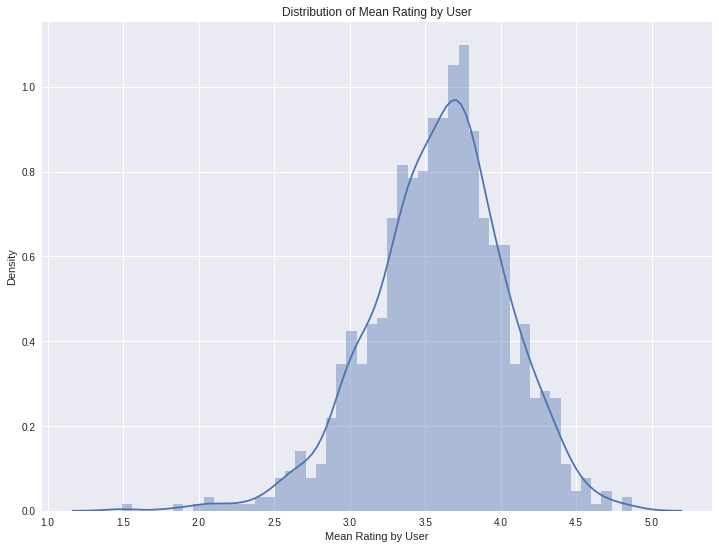

In [22]:
sns.distplot(user_rating_stats['user_mean'], bins=50)
plt.title('Distribution of Mean Rating by User')
plt.xlabel('Mean Rating by User')
plt.ylabel('Density')
plt.show()

In [23]:
user_rating_stats['user_mean'].describe()

count    943.000000
mean       3.588191
std        0.445233
min        1.491954
25%        3.323054
50%        3.620690
75%        3.869565
max        4.869565
Name: user_mean, dtype: float64

In [24]:
user_rating_stats['user_mean'].median()

3.6206896551724137

This is pretty close to the mean score for all movies.

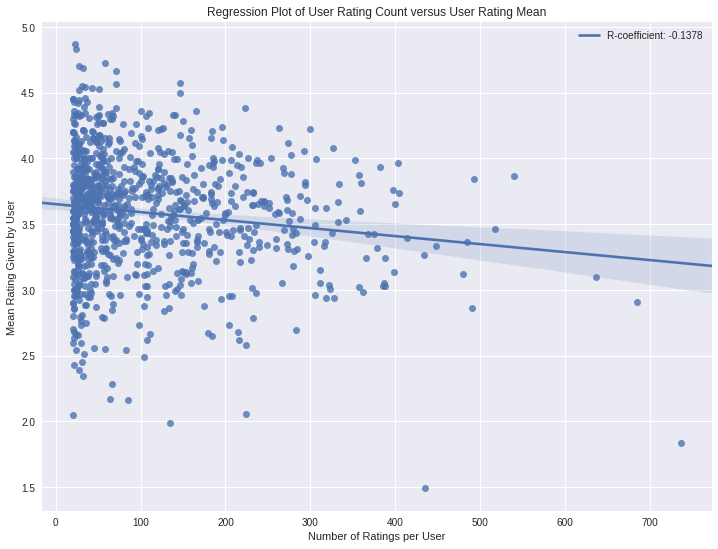

In [25]:
sns.regplot(user_rating_stats['user_count'], user_rating_stats['user_mean'])
plt.title('Regression Plot of User Rating Count versus User Rating Mean')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Mean Rating Given by User')
plt.legend(['R-coefficient: '+R_coeff(user_rating_stats['user_count'],
                                   user_rating_stats['user_mean'])])
plt.show()

In [26]:
stats.pearsonr(user_rating_stats['user_count'], user_rating_stats['user_mean'])

(-0.13779508142960803, 2.1751265996099447e-05)

There is a slight negative correlation between the number of movies a user has reviewed and their average rating for a movie.

#### Movies

In [27]:
# Get number of reviews provided for each movie.

movie_rating_count = ratings.groupby('movieId')['rating'].count()

movie_rating_count = pd.DataFrame(movie_rating_count).reset_index()
movie_rating_count.rename(columns={'rating': 'movie_count'}, inplace=True)

movie_rating_count.head()

,movieId,movie_count
0,1,452
1,2,131
2,3,90
3,4,209
4,5,86


In [28]:
movie_rating_mean = ratings.groupby('movieId')['rating'].mean()

movie_rating_mean = pd.DataFrame(movie_rating_mean).reset_index()
movie_rating_mean.rename(columns={'rating': 'movie_mean'}, inplace=True)

movie_rating_mean.head()

,movieId,movie_mean
0,1,3.878319
1,2,3.206107
2,3,3.033333
3,4,3.550239
4,5,3.302326


In [29]:
movie_rating_stats = pd.merge(movie_rating_count, movie_rating_mean, on='movieId')
movie_rating_stats.head()

,movieId,movie_count,movie_mean
0,1,452,3.878319
1,2,131,3.206107
2,3,90,3.033333
3,4,209,3.550239
4,5,86,3.302326


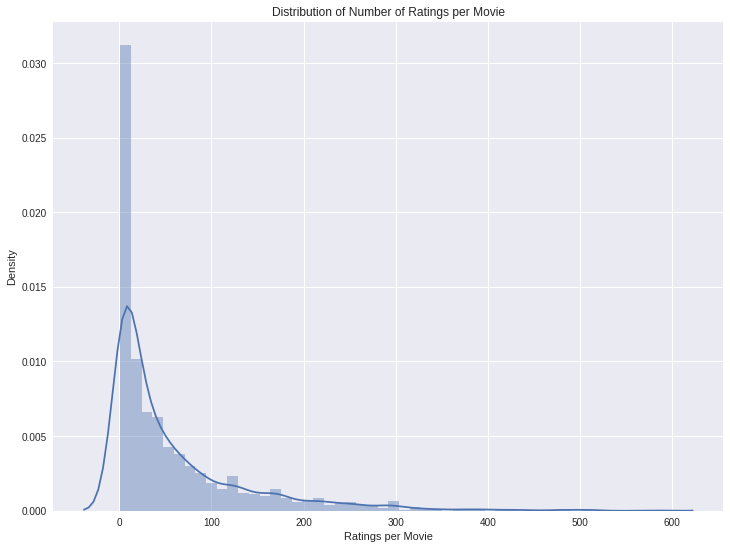

In [30]:
sns.distplot(movie_rating_stats['movie_count'], bins=50)
plt.title('Distribution of Number of Ratings per Movie')
plt.xlabel('Ratings per Movie')
plt.ylabel('Density')
plt.show()

In [31]:
movie_rating_stats['movie_count'].describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: movie_count, dtype: float64

In [32]:
movie_rating_stats['movie_count'].median()

27.0

Unlike users (who are only included in the dataset if they have reviewed 20 or more films), there is no minimum threshold for inclusion for movies. The median here is 27 ratings (2.9% of users have seen the film), but the maximum number of ratings is 583 (61.8% of users having seen the film.)

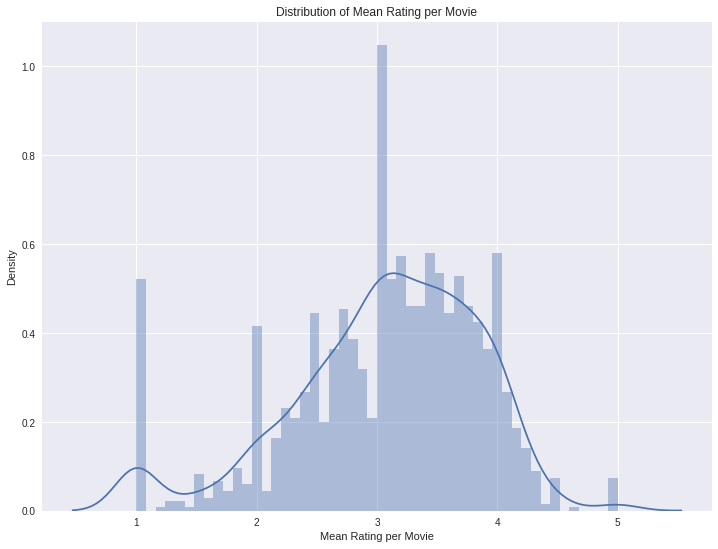

In [33]:
sns.distplot(movie_rating_stats['movie_mean'], bins=50)
plt.title('Distribution of Mean Rating per Movie')
plt.xlabel('Mean Rating per Movie')
plt.ylabel('Density')
plt.show()

In [34]:
movie_rating_stats['movie_mean'].describe()

count    1682.000000
mean        3.076045
std         0.781662
min         1.000000
25%         2.659600
50%         3.161528
75%         3.653428
max         5.000000
Name: movie_mean, dtype: float64

In [35]:
movie_rating_stats['movie_mean'].median()

3.1615275142314987

Unusual distribution of mean point scores near whole number values are due to movies in the dataset that only have a few ratings.

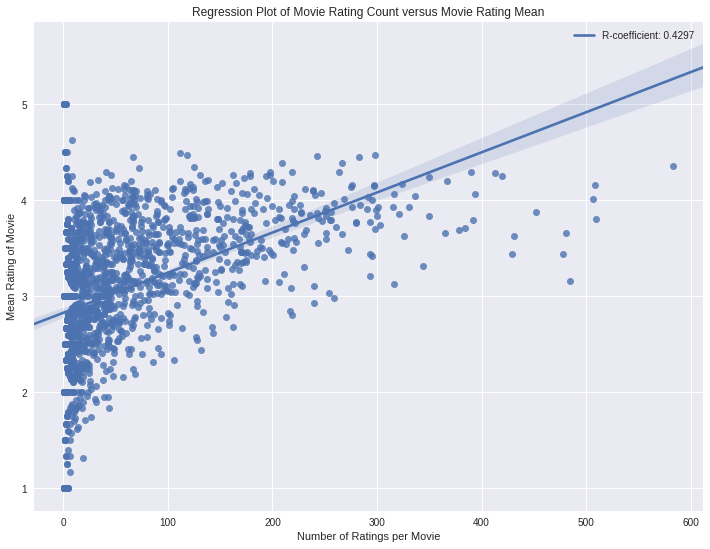

In [36]:
sns.regplot(movie_rating_stats['movie_count'], movie_rating_stats['movie_mean'])
plt.title('Regression Plot of Movie Rating Count versus Movie Rating Mean')
plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Mean Rating of Movie')
plt.legend(['R-coefficient: '+R_coeff(movie_rating_stats['movie_count'],
                                      movie_rating_stats['movie_mean'])])
plt.show()

In [37]:
stats.pearsonr(movie_rating_stats['movie_count'], movie_rating_stats['movie_mean'])

(0.4296591698676232, 1.5967054836586385e-76)

There is a moderate positive correlation between the number of ratings a movie has and its mean rating. Better movies tend to be more popular, while movies with fewer ratings (and likely fewer views) are more likely to have ratings that span the extremes of 1 and 5 points.

In [38]:
df_merged = pd.merge(ratings.drop(['timestamp'], 1),
                     items[['movieId', 'title']], on='movieId')

df_merged = pd.merge(df_merged, user_rating_stats, on='userId')

df_merged = pd.merge(df_merged, movie_rating_stats, on='movieId')

df_merged.head()

,userId,movieId,rating,title,user_count,user_mean,movie_count,movie_mean
0,196,242,3.0,Kolya (1996),39,3.615385,117,3.991453
1,63,242,3.0,Kolya (1996),93,3.118280,117,3.991453
2,226,242,5.0,Kolya (1996),50,3.800000,117,3.991453
3,154,242,3.0,Kolya (1996),51,3.960784,117,3.991453
4,306,242,5.0,Kolya (1996),32,3.781250,117,3.991453


## Most Popular Movies

In [39]:
df_merged.drop(['userId', 'movieId'], 1).groupby('title').mean().sort_values(by='movie_count',
                                                      ascending=False).head(20)

,rating,user_count,user_mean,movie_count,movie_mean
title,,,,,
Star Wars (1977),4.358491,140.624357,3.608816,583.0,4.358491
Contact (1997),3.803536,119.418468,3.531827,509.0,3.803536
Fargo (1996),4.155512,142.080709,3.600765,508.0,4.155512
Return of the Jedi (1983),4.007890,148.802761,3.583099,507.0,4.007890
Liar Liar (1997),3.156701,119.292784,3.525744,485.0,3.156701
"English Patient, The (1996)",3.656965,109.195426,3.568388,481.0,3.656965
Scream (1996),3.441423,119.707113,3.524495,478.0,3.441423
Toy Story (1995),3.878319,146.424779,3.579055,452.0,3.878319
Air Force One (1997),3.631090,106.549884,3.522442,431.0,3.631090


## Highest-Rated Movies

In [40]:
df_merged.drop(['userId', 'movieId'],1).groupby('title').mean().sort_values(by='movie_mean',
                                                      ascending=False).head(20)

,rating,user_count,user_mean,movie_count,movie_mean
title,,,,,
They Made Me a Criminal (1939),5.000000,208.000000,4.086538,1.0,5.000000
Marlene Dietrich: Shadow and Light (1996),5.000000,300.000000,4.223333,1.0,5.000000
"Saint of Fort Washington, The (1993)",5.000000,239.000000,3.506880,2.0,5.000000
Someone Else's America (1995),5.000000,263.000000,3.581749,1.0,5.000000
Star Kid (1997),5.000000,62.333333,3.822636,3.0,5.000000
"Great Day in Harlem, A (1994)",5.000000,636.000000,3.097484,1.0,5.000000
Aiqing wansui (1994),5.000000,281.000000,3.295374,1.0,5.000000
Santa with Muscles (1996),5.000000,238.000000,3.526498,2.0,5.000000
Prefontaine (1997),5.000000,326.000000,3.919250,3.0,5.000000


 Here, we are likely seeing some bias due to small sample size. This so-called "cold start" problem presents an obstacle for building effective recommendation algorithms; when a user or an item has only a tiny number of associated ratings, it's hard to reliably predict the rating.

However, we will keep these in the dataset because there is still substantial user information paired with the movies with low counts (the user who rated "Entertaining Angels" has only rated 34 films, but most of the users who have rated these less-popular films have a high mean user_count, meaning that they have on average rated hundreds of movies.)

## Breakdown by Genre

In [0]:
# Sort genres by larges proportion of dataset

g_proport = pd.DataFrame()
proportions = []

for genre in genrelist:
  proportion = np.round(100 * (len(items[items[genre] == 1])/ len(items)), 2)
  proportions.append(float(proportion))
  
g_proport['genre'] = genrelist
g_proport['proportions'] = proportions
g_proport['prop_string'] = g_proport['proportions'].apply(lambda x: str(np.round(x, 2)))

g_proport = g_proport.sort_values(by='proportions', ascending=False)

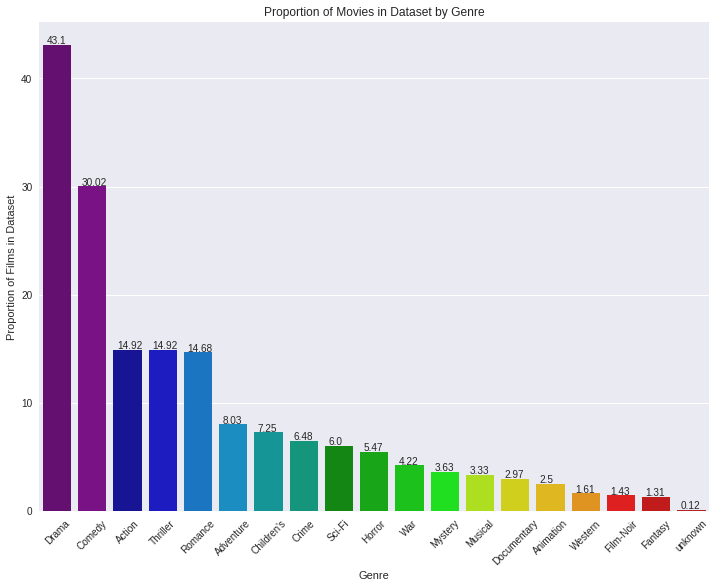

In [42]:
plt.title('Proportion of Movies in Dataset by Genre')
ax = sns.barplot(x='genre', y='proportions', data=g_proport, palette='nipy_spectral')
plt.ylabel('Proportion of Films in Dataset')
plt.xlabel('Genre')
plt.xticks(rotation=45)

yposlist = list(g_proport['proportions'])
yposlist = [pos + 0.1 for pos in yposlist]
xposlist = range(len(yposlist))
xposlist = [pos-0.3 for pos in xposlist]
stringlist = g_proport['prop_string']

for i in range(len(stringlist)):
    ax.text(xposlist[i], yposlist[i],
          g_proport[g_proport['proportions'] == yposlist[i]-0.1]['prop_string'].values[0],
            fontsize=10)
    
plt.show()

In [43]:
df_genre = pd.merge(items, movie_rating_stats, on='movieId')

df_genre.head()

,movieId,title,release,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_count,movie_mean
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,452,3.878319
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,131,3.206107
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,90,3.033333
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,209,3.550239
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,86,3.302326


In [0]:
# Sort genres by highest mean rating.

g_ratings = pd.DataFrame()
genre_ratings = []

for genre in genrelist:
  genre_rating = df_genre[df_genre[genre] == 1]['movie_mean'].mean()
  genre_ratings.append(genre_rating)

g_ratings['genre'] = genrelist
g_ratings['mean_rating'] = genre_ratings
g_ratings['mean_string'] = g_ratings['mean_rating'].apply(lambda x: str(np.round(x, 2)))

g_ratings = g_ratings.sort_values(by='mean_rating', ascending=False)

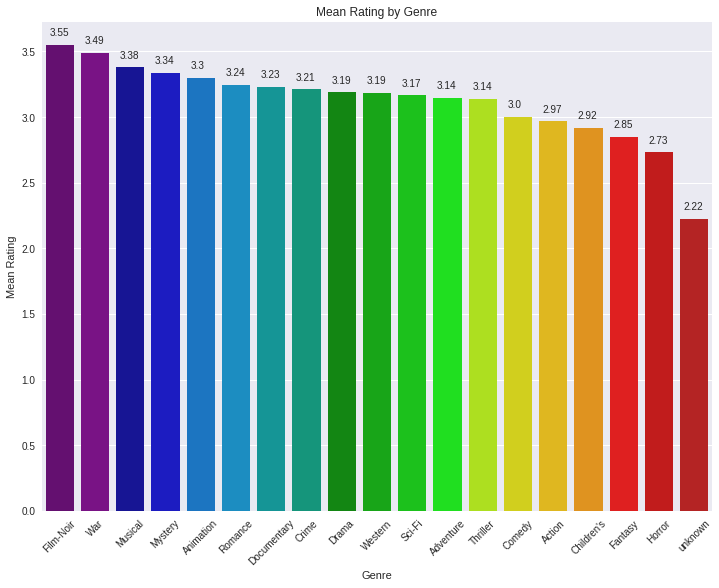

In [45]:
plt.title('Mean Rating by Genre')
ax = sns.barplot(x='genre', y='mean_rating', data=g_ratings, palette='nipy_spectral')
plt.ylabel('Mean Rating')
plt.xlabel('Genre')
plt.xticks(rotation=45)

yposlist = list(g_ratings['mean_rating'])
yposlist = [pos + 0.07 for pos in yposlist]
xposlist = range(len(yposlist))
xposlist = [pos-0.3 for pos in xposlist]
stringlist = g_ratings['mean_string']

for i in range(len(stringlist)):
    ax.text(xposlist[i], yposlist[i],
          g_ratings[g_ratings['mean_rating'] == yposlist[i]-0.07]['mean_string'].values[0],
            fontsize=10)
    
plt.show()

In [0]:
df_genre['n_genres'] = df_genre[genrelist].sum(axis=1)

In [47]:
df_genre['n_genres'].value_counts()

1    833
2    569
3    215
4     51
5     11
6      3
Name: n_genres, dtype: int64

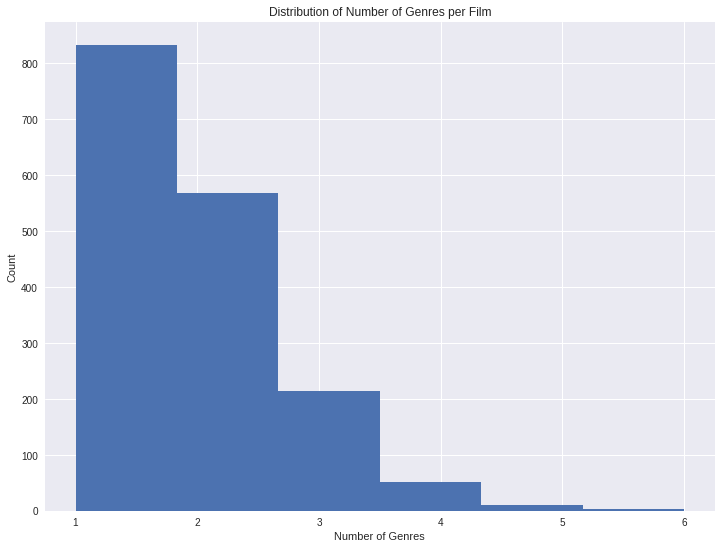

In [48]:
plt.title('Distribution of Number of Genres per Film')
plt.hist(df_genre['n_genres'], bins=6)
plt.xlabel('Number of Genres')
plt.ylabel('Count')
plt.show()

In [49]:
# Movies in the most genre categories:

df_genre[df_genre['n_genres'] == df_genre['n_genres'].max()]

,movieId,title,release,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,movie_count,movie_mean,n_genres
171,172,"Empire Strikes Back, The (1980)",01-Jan-1980,0,1,1,0,0,0,0,...,0,0,1,1,0,1,0,367,4.204360,6
425,426,"Transformers: The Movie, The (1986)",01-Jan-1986,0,1,0,1,1,0,0,...,0,0,0,1,1,1,0,32,2.843750,6
559,560,"Kid in King Arthur's Court, A (1995)",01-Jan-1995,0,0,1,0,1,1,0,...,0,0,1,1,0,0,0,22,2.727273,6


Genre is n-hot-encoded to represent movies that fit multiple categories. This may seem like it makes things more complicated, but it actually means we have a richer dataset than we would if genre were one-hot-encoded.

As it is 20 years old, the list of genres doesn't necessarily account for how these movies would be categorized today (e.g.: the Star Wars films would likely fall under a "space opera" subcategory of science fiction.) Nevertheless, it appears to be a good starting point for understanding user preferences from a top-down perspective.

# Supervised Model

## Feature Engineering

Without using matrix factorization (or neural networks), we can still approximate the effect of vector embeddings by creating new features based on users' genre preferences. Indicators of those preferences may include the proportion of movies of each genre the user has watched, the mean rating each user assigns movies of a particular genre. 

We can combine these with the movies' n-hot-encoded genres and their average ratings to achieve an effect similar to matrix factorization-driven collaborative filtering. Here, though, we are explicitly assigning importance based on the supplied categories, rather than relying on latent factors.

This carries with it the advantage of interpretability, but also the disadvantage of biases present in the genre labeling system. Matrix factorization can help account for patterns that are not explicitly stated, and would therefore be excluded from the supervised model.

In [0]:
# A try-except block lets us avoid having to run this more than once.

try:
  df_supervised = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/df_supervised.csv',
                        index_col=0)
except FileNotFoundError:
  # Create DataFrame as a space to create supervised learning features:
  
  df_supervised = pd.merge(df_merged, items[['movieId'] + genrelist],
                           on='movieId')

  # User count in this context will mean "other movies reviewed" instead of
  # "total movies reviewed." Therefore, we decrease the total count by 1.
  df_supervised['user_count'] = df_supervised['user_count'] - 1
  
  
  # Create features representing average ratings user has given movies of
  # specific genres, excluding ratings given to the film in question.
  
  # Because of the conditional complexity of this operation, we're going to use
  # for loops instead of list comprehensions.
  
  for genre in genrelist:

    columnname1 = genre + '_mean'
    columnname2 = genre + '_count'
    print(genre)

    other_means = []
    other_counts = []

    for userid, movieid in zip(df_supervised['userId'], df_supervised['movieId']):
      
      # Only average user's ratings of other films:
      conditions = (df_supervised[genre] == 1) & (df_supervised['userId'] == userid) & (df_supervised['movieId'] != movieid)

      if len(df_supervised[conditions]) == 0:

        other_means.append(0)
        other_counts.append(0)

      else:

        other_means.append(df_supervised[conditions]['rating'].mean())
        other_counts.append(df_supervised[conditions]['rating'].count())

    df_supervised[columnname1] = other_means
    df_supervised[columnname2] = other_counts
  
  
  # Create mean score for each user/movie pair that excludes current movie/user
  movie_other_means = []
  user_other_means = []

  for userid, movieid in zip(df_supervised['userId'], df_supervised['movieId']):
    
    # Only average movie's ratings by other users:
    movie_other_means.append(df_supervised[(df_supervised['userId'] != userid) & (df_supervised['movieId'] == movieId)]['rating'].mean())
    
    # Only average user's ratings of other films:
    user_other_means.append(df_supervised[(df_supervised['movieId'] != movieId) & (df_supervised['userId'] == userId)]['rating'].mean())

  df_supervised['movie_other_means'] = movie_other_means
  df_supervised['user_other_means'] = user_other_means
  
  for genre in genrelist:
    
    # Get proportion of films of a given genre that a user has rated:
    columnname3 = genre + '_proportion'

    df_supervised[columnname3] = df_supervised[genre+'_count'] / df_supervised['user_count']

This takes a while to run, so we've saved it as a .csv file.

In [0]:
try:
  df_supervised = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/df_supervised.csv',
                        index_col=0)
except FileNotFoundError:
  df_supervised.to_csv('/content/drive/Colab Notebooks/ml-100k/df_supervised.csv')
  df_supervised = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/df_supervised.csv',
                      index_col=0)

In [52]:
df_supervised.head()

,userId,movieId,rating,title,user_count,user_mean,movie_count,movie_mean,unknown,Action,...,Fantasy_proportion,Film-Noir_proportion,Horror_proportion,Musical_proportion,Mystery_proportion,Romance_proportion,Sci-Fi_proportion,Thriller_proportion,War_proportion,Western_proportion
0,196,242,3,Kolya (1996),39,3.615385,117,3.991453,0,0,...,0.025641,0.000000,0.000000,0.000000,0.000000,0.282051,0.051282,0.000000,0.051282,0.00
1,63,242,3,Kolya (1996),93,3.118280,117,3.991453,0,0,...,0.000000,0.010753,0.010753,0.043011,0.053763,0.204301,0.086022,0.225806,0.053763,0.00
2,226,242,5,Kolya (1996),50,3.800000,117,3.991453,0,0,...,0.000000,0.020000,0.000000,0.040000,0.060000,0.120000,0.180000,0.220000,0.100000,0.04
3,154,242,3,Kolya (1996),51,3.960784,117,3.991453,0,0,...,0.000000,0.098039,0.058824,0.039216,0.156863,0.156863,0.196078,0.156863,0.156863,0.00
4,306,242,5,Kolya (1996),32,3.781250,117,3.991453,0,0,...,0.000000,0.000000,0.000000,0.062500,0.000000,0.250000,0.093750,0.062500,0.093750,0.00


In [0]:
# Organize features by genre:

meanlist = [genre+'_mean' for genre in genrelist]
proportionlist = [genre+'_proportion' for genre in genrelist]

#### Final Feature Selection

In [0]:
features_super = pd.DataFrame(df_supervised[['userId', 'movieId', 'rating', 'user_other_means',
                           'movie_other_means'] + meanlist + genrelist + proportionlist])

In [55]:
features_super.head()

,userId,movieId,rating,user_other_means,movie_other_means,unknown_mean,Action_mean,Adventure_mean,Animation_mean,Children's_mean,...,Fantasy_proportion,Film-Noir_proportion,Horror_proportion,Musical_proportion,Mystery_proportion,Romance_proportion,Sci-Fi_proportion,Thriller_proportion,War_proportion,Western_proportion
0,196,242,3,3.631579,4.000000,0.0,1.666667,2.500,0.000000,4.00,...,0.025641,0.000000,0.000000,0.000000,0.000000,0.282051,0.051282,0.000000,0.051282,0.00
1,63,242,3,3.631579,4.000000,0.0,2.800000,2.875,2.600000,2.25,...,0.000000,0.010753,0.010753,0.043011,0.053763,0.204301,0.086022,0.225806,0.053763,0.00
2,226,242,5,3.631579,3.982759,0.0,3.625000,3.750,4.333333,3.00,...,0.000000,0.020000,0.000000,0.040000,0.060000,0.120000,0.180000,0.220000,0.100000,0.04
3,154,242,3,3.631579,4.000000,0.0,4.125000,4.000,0.000000,0.00,...,0.000000,0.098039,0.058824,0.039216,0.156863,0.156863,0.196078,0.156863,0.156863,0.00
4,306,242,5,3.631579,3.982759,0.0,4.000000,4.000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.062500,0.000000,0.250000,0.093750,0.062500,0.093750,0.00


#### Correlation Matrix Heatmap

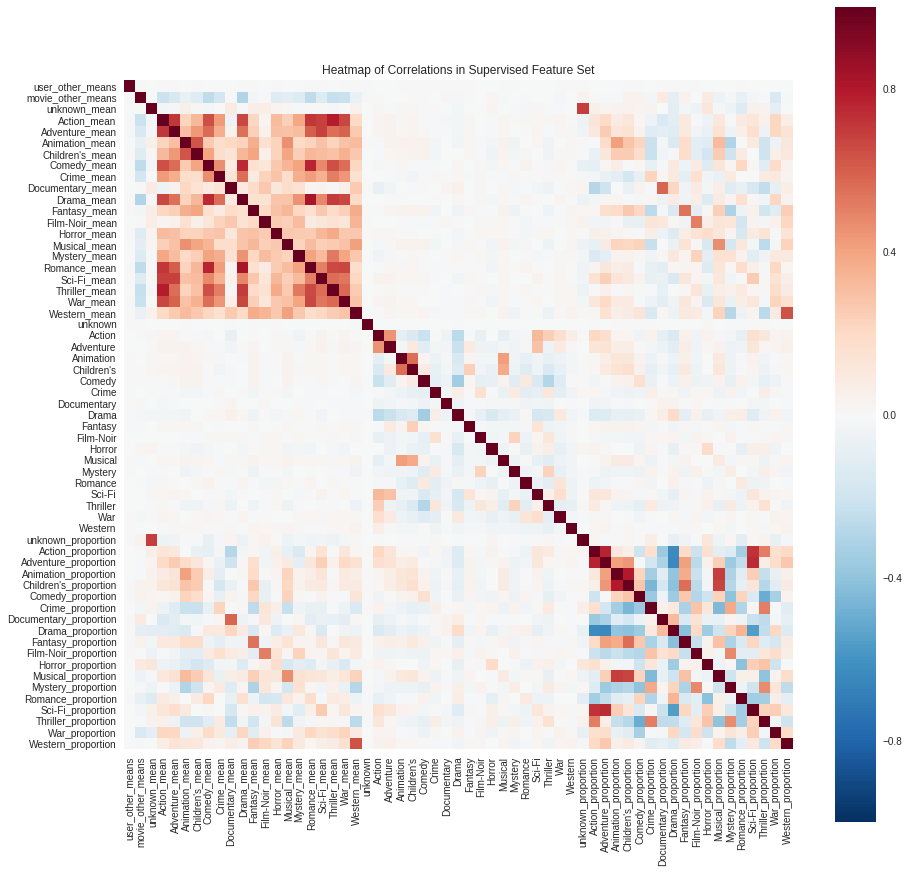

In [56]:
# Visualization of correlations between features in supervised feature set.

plt.rcParams['figure.figsize'] = 15, 15

plt.title('Heatmap of Correlations in Supervised Feature Set')
sns.heatmap(features_super.drop(['rating', 'userId', 'movieId'], 1).corr(),
            square=True)
plt.show()

plt.rcParams['figure.figsize'] = 12, 9

Features for the supervised models include the mean rating the user has given other movies, the mean rating other users have given the movie, the mean rating the user has given movies of each provided genre (excluding the movie in question), and the proportion of movies of each genre the user has watched (also excluding the movie in question).

Because the mean scores and proportions are calculated per pair of user and movie, feature creation was quite computationally complex, requiring a new mean to be calculated for each movie that excludes information based on the rating relationship between specific movie and specific user.

We see some collinearity here between features connected with some genres, such as "Action-Adventure" and "Children's-Animation." This is somewhat unavoidable because of the overlapping nature of genre features, so we won't worry too much about it for now.

##SKLearn Models:

In [0]:
# We will use RMSE as our loss measurement because it is sensitive to large
# deviations from ground truth. "rmse" is already occupied by a fast.ai function.

def sk_rmse(y_true, y_pred):
  """Root Mean-Squared Error. Follows same input
     structure as mean_squared_error in SKLearn"""
  return np.sqrt(mse(y_true, y_pred))

Ordinarily, we'd use something closer to 67-33 or 70-30 for SKLearn models, and 90-10 for neural net models, so we're compromising with an 80-20 split.


In [0]:
X = features_super.drop(['rating'], 1)
y = features_super['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                      test_size=0.2, random_state=0)

### Multinomial Logistic Regression

In [59]:
# Discrete value output may not be as effective as continuous regression output.

logit = LogisticRegression(solver='saga', multi_class='multinomial')

logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [60]:
# R-squared coefficient:

logit.score(X_train, y_train)

0.36245

In [61]:
# R-squared coefficient:

logit.score(X_test, y_test)

0.36795

In [62]:
# Calculate root mean-squared error for train set:

sk_rmse(y_train, logit.predict(X_train))

1.1203961353021528

In [63]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, logit.predict(X_test))

1.1153474794878948

The loss here is fairly high... we'd like to reduce it to within a star rating if possible, and ideally below the lowest listed benchmark for this datset from [librec.net](https://www.librec.net/release/v1.3/example.html), 0.911 RMSE.

### Linear Regression

In [64]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [65]:
# R-squared coefficient:

lr.score(X_train, y_train)

0.19017741737113644

In [66]:
# R-squared coefficient:

lr.score(X_test, y_test)

0.1868082201428708

In [67]:
# Calculate root mean-squared error for train set:

sk_rmse(y_train, lr.predict(X_train))

1.0139488293649401

In [68]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, lr.predict(X_test))

1.0111720569777796

In [69]:
# RMSE for rounded prediction:

sk_rmse(y_test, np.round(lr.predict(X_test), 0))

1.0540398474441086

Linear regression doesn't seem to be getting us anywhere, either, as the error is only slightly better than multinomial logistic regression. Let's try a random forest regressor model... this should help deal with the inherent collinearity of our features:

### Random Forest Regression

#### n_estimators = 10 (current SKLearn default)

In [70]:
rfr = RandomForestRegressor(n_jobs=-1)

rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [71]:
# R-squared coefficient:

rfr.score(X_train, y_train)

0.9196975007007712

In [72]:
# R-squared coefficient:

rfr.score(X_test, y_test)

0.5535528947341717

In [73]:
# Calculate root mean-squared error for test set:

sk_rmse(y_train, rfr.predict(X_train))

0.3192902284755987

In [74]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, rfr.predict(X_test))

0.7492272685907795

In [75]:
# RMSE for rounded prediction:

sk_rmse(y_test, np.round(rfr.predict(X_test), 0))

0.7854934754662193

 There appears to be quite a bit of overfitting, but that root mean-squared error is much better. We've surpassed the benchmark already! Let's see if that can be improved by adding more trees to the forest.

#### n_estimators = 100 (future SKLearn default)

In [76]:
rfr2 = RandomForestRegressor(n_estimators=100, n_jobs=-1)

rfr2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [77]:
# R-squared coefficient:

rfr2.score(X_train, y_train)

0.945115107087989

In [78]:
# R-squared coefficient:

rfr2.score(X_test, y_test)

0.6060678230029892

In [79]:
# Calculate root mean-squared error for train set:

sk_rmse(y_train, rfr2.predict(X_train))

0.2639657056323794

In [80]:
# Calculate root mean-squared error for test set:

sk_rmse(y_test, rfr2.predict(X_test))

0.7037838517613203

In [81]:
# RMSE for rounded prediction:

sk_rmse(y_test, np.round(rfr2.predict(X_test), 0))

0.7427651041883968

Even better! Let's try a grid search with cross validation and see how low and how consistent we can make that error score.

### Cross-Validation Sets

Ordinarily, we'd use GridSearchCV and cross_val_score for k-folds validation, but we'd like to compare the results of this grid search as precisely as we can to the neural network models. Since SKLearn's cross_val_score splits the data into k folds internally, and we want to be able to access those folds outside of SKLearn models, we'll have to do this part manually using pandas' .sample().

In [0]:
# Create test set indices for cross-validation:
test_index_a = list(df_merged.sample(20000, random_state=0).index.sort_values())
test_index_b = list(df_merged[~df_merged.index.isin(test_index_a)].sample(20000,
                              random_state=0).index.sort_values())
sampled = test_index_a + test_index_b
test_index_c = list(df_merged[~df_merged.index.isin(sampled)].sample(20000,
                              random_state=0).index.sort_values())
sampled += test_index_c
test_index_d = list(df_merged[~df_merged.index.isin(sampled)].sample(20000,
                              random_state=0).index.sort_values())
sampled += test_index_d
test_index_e = list(df_merged[~df_merged.index.isin(sampled)].index.sort_values())

# List of indices for test sets:
test_indices = [test_index_a, test_index_b, test_index_c,
                test_index_d, test_index_e]

# Create training set indices for cross-validation:
train_index_a = df_merged[~df_merged.index.isin(test_index_a)].index.sort_values().tolist()
train_index_b = df_merged[~df_merged.index.isin(test_index_b)].index.sort_values().tolist()
train_index_c = df_merged[~df_merged.index.isin(test_index_c)].index.sort_values().tolist()
train_index_d = df_merged[~df_merged.index.isin(test_index_d)].index.sort_values().tolist()
train_index_e = df_merged[~df_merged.index.isin(test_index_e)].index.sort_values().tolist()

# List of indices for train sets:
train_indices = [train_index_a, train_index_b, train_index_c,
                 train_index_d, train_index_e]

In [0]:
# Train-test split will use the same index values as the other models:

X_train_a = features_super.iloc[train_index_a].drop(['rating'], 1)
X_test_a = features_super.iloc[test_index_a].drop(['rating'], 1)
X_train_b = features_super.iloc[train_index_b].drop(['rating'], 1)
X_test_b = features_super.iloc[test_index_b].drop(['rating'], 1)
X_train_c = features_super.iloc[train_index_c].drop(['rating'], 1)
X_test_c = features_super.iloc[test_index_c].drop(['rating'], 1)
X_train_d = features_super.iloc[train_index_d].drop(['rating'], 1)
X_test_d = features_super.iloc[test_index_d].drop(['rating'], 1)
X_train_e = features_super.iloc[train_index_e].drop(['rating'], 1)
X_test_e = features_super.iloc[test_index_e].drop(['rating'], 1)

y_train_a = features_super.iloc[train_index_a]['rating'].values
y_test_a = features_super.iloc[test_index_a]['rating'].values
y_train_b = features_super.iloc[train_index_b]['rating'].values
y_test_b = features_super.iloc[test_index_b]['rating'].values
y_train_c = features_super.iloc[train_index_c]['rating'].values
y_test_c = features_super.iloc[test_index_c]['rating'].values
y_train_d = features_super.iloc[train_index_d]['rating'].values
y_test_d = features_super.iloc[test_index_d]['rating'].values
y_train_e = features_super.iloc[train_index_e]['rating'].values
y_test_e = features_super.iloc[test_index_e]['rating'].values

folds = ['a', 'b', 'c', 'd', 'e']

X_trains = [X_train_a, X_train_b, X_train_c, X_train_d, X_train_e]
X_tests = [X_test_a, X_test_b, X_test_c, X_test_d, X_test_e]
y_trains = [y_train_a, y_train_b, y_train_c, y_train_d, y_train_e]
y_tests = [y_test_a, y_test_b, y_test_c, y_test_d, y_test_e]

### Grid Search

In [0]:
parameter_space_rfr = {'min_samples_split':[2, 4, 8], 'n_estimators':[50, 100, 150]}

In [0]:
try:
  rfr_gridsearch = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/rfr_gridsearch.csv',
                        index_col=0)
except FileNotFoundError:
  #Create empty DataFrame to hold grid search data:
  rfr_gridsearch = pd.DataFrame()
  
  #Create empty lists to be turned into DataFrame

  namelist_rfr = []

  trainloss_a = []
  trainloss_b = []
  trainloss_c = []
  trainloss_d = []
  trainloss_e = []

  testloss_a = []
  testloss_b = []
  testloss_c = []
  testloss_d = []
  testloss_e = []


  for min_samples_split in parameter_space_rfr['min_samples_split']:
    for n_estimators in parameter_space_rfr['n_estimators']:

      algoname = 'RFR_min_samples:{}_n_estimators:{}'.format(min_samples_split,
                                                          n_estimators)
      namelist_rfr.append(algoname)
      print(algoname)

      trainlosses = []
      testlosses = []
      
      kfoldsset = zip(folds, X_trains, X_tests, y_trains, y_tests)
      
      for fold, X_train, X_test, y_train, y_test in kfoldsset:
        print(fold)
        rfr = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1,
                       min_samples_split=min_samples_split)
        rfr.fit(X_train, y_train)
        trainlosses.append(sk_rmse(y_train, np.round(rfr.predict(X_train), 0)))
        print(trainlosses[-1])
        testlosses.append(sk_rmse(y_test, np.round(rfr.predict(X_test), 0)))
        print(testlosses[-1])

      trainloss_a.append(trainlosses[0])
      trainloss_b.append(trainlosses[1])
      trainloss_c.append(trainlosses[2])
      trainloss_d.append(trainlosses[3])
      trainloss_e.append(trainlosses[4])

      testloss_a.append(testlosses[0])
      testloss_b.append(testlosses[1])
      testloss_c.append(testlosses[2])
      testloss_d.append(testlosses[3])
      testloss_e.append(testlosses[4])

  rfr_gridsearch['parameter_list'] = namelist_rfr

  rfr_gridsearch['trainloss_a'] = trainloss_a
  rfr_gridsearch['trainloss_b'] = trainloss_b
  rfr_gridsearch['trainloss_c'] = trainloss_c
  rfr_gridsearch['trainloss_d'] = trainloss_d
  rfr_gridsearch['trainloss_e'] = trainloss_e

  rfr_gridsearch['testloss_a'] = testloss_a
  rfr_gridsearch['testloss_b'] = testloss_b
  rfr_gridsearch['testloss_c'] = testloss_c
  rfr_gridsearch['testloss_d'] = testloss_d
  rfr_gridsearch['testloss_e'] = testloss_e

  rfr_gridsearch['mean_train_loss'] = rfr_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].mean(axis=1)

  rfr_gridsearch['mean_test_loss'] = rfr_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].mean(axis=1)
  
  rfr_gridsearch['train_loss_std'] = rfr_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].std(axis=1)
  
  rfr_gridsearch['test_loss_std'] = rfr_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].std(axis=1)

  rfr_gridsearch.to_csv('/content/drive/Colab Notebooks/ml-100k/rfr_gridsearch.csv')

In [86]:
# Results of Random Forest Regression grid search:

rfr_gridsearch

,parameter_list,trainloss_a,trainloss_b,trainloss_c,trainloss_d,trainloss_e,testloss_a,testloss_b,testloss_c,testloss_d,testloss_e,mean_train_loss,mean_test_loss,train_loss_std,test_loss_std
0,RFR_min_samples:2_n_estimators:50,0.276451,0.274818,0.277579,0.275772,0.271270,0.723533,0.723948,0.720069,0.736750,0.717948,0.275178,0.724450,0.002405,0.007312
1,RFR_min_samples:2_n_estimators:100,0.265212,0.267465,0.267652,0.265683,0.262631,0.715577,0.719757,0.715192,0.729178,0.708943,0.265729,0.717729,0.002036,0.007474
2,RFR_min_samples:2_n_estimators:150,0.262059,0.264457,0.266857,0.263439,0.261630,0.715786,0.718610,0.715647,0.725362,0.711372,0.263688,0.717355,0.002097,0.005169
3,RFR_min_samples:4_n_estimators:50,0.301683,0.307571,0.311308,0.305082,0.302861,0.723118,0.729349,0.728217,0.735051,0.721838,0.305701,0.727515,0.003858,0.005296
4,RFR_min_samples:4_n_estimators:100,0.301144,0.303624,0.300666,0.299291,0.296648,0.727049,0.724638,0.715367,0.729863,0.724396,0.300274,0.724263,0.002562,0.005441
5,RFR_min_samples:4_n_estimators:150,0.295148,0.299958,0.300874,0.298454,0.293854,0.721561,0.724534,0.720347,0.737360,0.715472,0.297658,0.723855,0.003043,0.008226
6,RFR_min_samples:8_n_estimators:50,0.391376,0.394176,0.393383,0.390224,0.387540,0.748498,0.743606,0.742698,0.755017,0.744077,0.391340,0.746779,0.002641,0.005120
7,RFR_min_samples:8_n_estimators:100,0.387524,0.386264,0.389744,0.387653,0.382083,0.745218,0.739730,0.743034,0.760559,0.735697,0.386654,0.744848,0.002844,0.009489
8,RFR_min_samples:8_n_estimators:150,0.382067,0.387605,0.386410,0.388008,0.379951,0.738343,0.742462,0.740034,0.757298,0.738241,0.384808,0.743276,0.003596,0.008023


In [87]:
rfr_gridsearch[rfr_gridsearch['mean_test_loss'] == rfr_gridsearch['mean_test_loss'].min()]

,parameter_list,trainloss_a,trainloss_b,trainloss_c,trainloss_d,trainloss_e,testloss_a,testloss_b,testloss_c,testloss_d,testloss_e,mean_train_loss,mean_test_loss,train_loss_std,test_loss_std
2,RFR_min_samples:2_n_estimators:150,0.262059,0.264457,0.266857,0.263439,0.26163,0.715786,0.71861,0.715647,0.725362,0.711372,0.263688,0.717355,0.002097,0.005169


0.727 RMSE is the new error number to beat! Next, we will try some  neural net models for matrix factorization.

# Neural Net Modeling

## fast.ai Model (Collab)

fast.ai, a research foundation and Massive Online Open Classroom, has its own machine learning modules built on top of PyTorch. The models contained therein are usable out-of-the-box with very little setup, and therefore provide a good starting point both for beginning ML practitioners, and as a sort of benchmark for other machine learning models.

Some of the objects in their module are very similar to pandas objects (such as "DataBunch" instead of "DataFrame"), but contain other information.

The ease of use provided by the fast.ai library does come with the drawback of less flexibility in terms of parameter adjustment, and insight into what the models are actually *doing*.

In [0]:
data = CollabDataBunch.from_df(df_merged[['userId', 'movieId', 'rating', 'title']],
                               seed=0, pct_val=0.2, item_name='title')

In [89]:
data.batch_size

64

In [90]:
data.show_batch()

userId,title,target
610,Psycho (1960),5.0
892,Under Siege (1992),5.0
285,"Shawshank Redemption, The (1994)",3.0
551,Star Wars (1977),2.0
367,Stephen King's The Langoliers (1995),4.0


In [0]:
y_range = [0, 5.5]

We'll first try a few different numbers of latent factors, and see roughly what we should aim for.

### 15 Factors

In [0]:
learn0 = collab_learner(data, n_factors=15, y_range=y_range, wd=5e-2, callback_fns=[CSVLogger])

In [93]:
learn0.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss
1,0.975743,0.943212
2,0.866624,0.858313
3,0.777894,0.822165
4,0.741836,0.808611
5,0.663068,0.807875


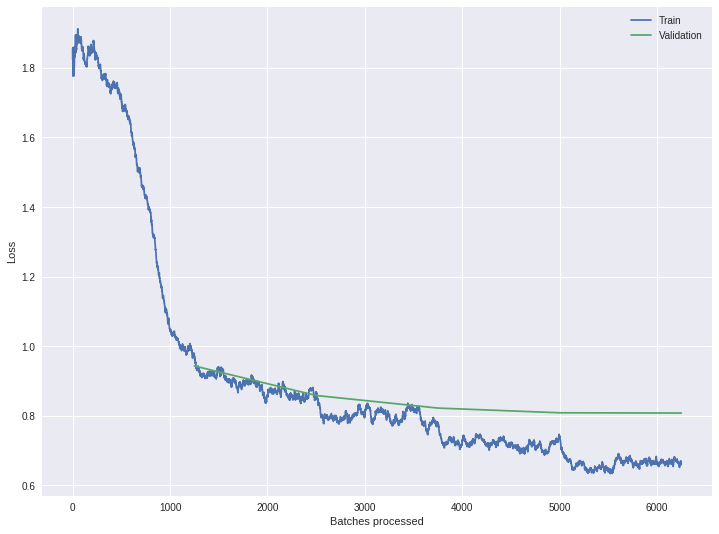

In [94]:
learn0.fit_one_cycle(5, 5e-3, moms=(0.95, 0.85))
learn0.recorder.plot_losses()

In [0]:
learn0_table = learn0.csv_logger.read_logged_file()

In [96]:
learn0_table

,epoch,train_loss,valid_loss
0,1,0.975743,0.943212
1,2,0.866624,0.858313
2,3,0.777894,0.822165
3,4,0.741836,0.808611
4,5,0.663068,0.807875


In [97]:
# Calculate RMSE from Mean-Squared Error

fai_train_rmse = np.sqrt(learn0_table.train_loss.values[-1])
fai_valid_rmse = np.sqrt(learn0_table.valid_loss.values[-1])

print("Training loss:", fai_train_rmse)
print("Validation loss", fai_valid_rmse)

Training loss: 0.8142898746760886
Validation loss 0.8988186691430035


### 30 Factors

In [0]:
learn1 = collab_learner(data, n_factors=30, y_range=y_range, wd=5e-2, callback_fns=[CSVLogger])

In [99]:
learn1.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss
1,0.937056,0.937437
2,0.870066,0.858537
3,0.759957,0.821885
4,0.606395,0.811147
5,0.527309,0.813012


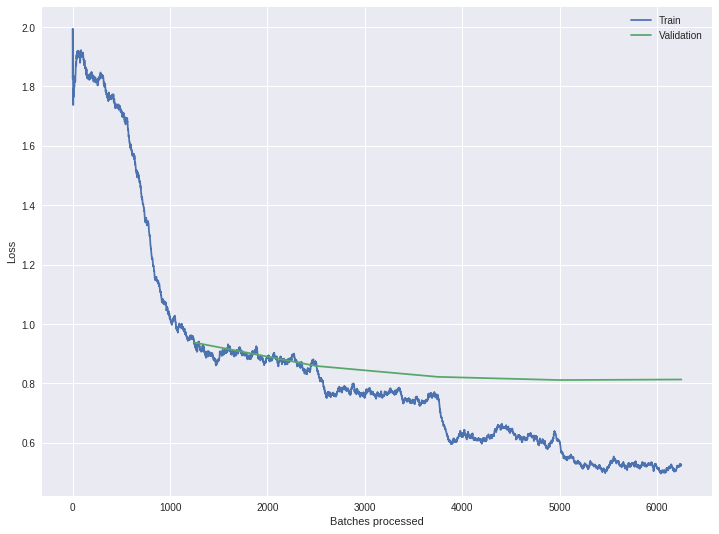

In [100]:
learn1.fit_one_cycle(5, 5e-3, moms=(0.95, 0.85))
learn1.recorder.plot_losses()

In [0]:
learn1_table = learn1.csv_logger.read_logged_file()

In [102]:
learn1_table

,epoch,train_loss,valid_loss
0,1,0.937056,0.937437
1,2,0.870066,0.858537
2,3,0.759957,0.821885
3,4,0.606395,0.811147
4,5,0.527309,0.813012


In [103]:
# Calculate RMSE from Mean-Squared Error

fai_train_rmse = np.sqrt(learn1_table.train_loss.values[-1])
fai_valid_rmse = np.sqrt(learn1_table.valid_loss.values[-1])

print("Training loss:", fai_train_rmse)
print("Validation loss", fai_valid_rmse)

Training loss: 0.726160450589262
Validation loss 0.9016717806386091


### 45 Factors

In [0]:
learn2 = collab_learner(data, n_factors=45, y_range=y_range, wd=5e-2, callback_fns=[CSVLogger])

In [105]:
learn2.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss
1,0.942422,0.937869
2,0.844139,0.857146
3,0.720331,0.825792
4,0.538179,0.825705
5,0.415496,0.828844


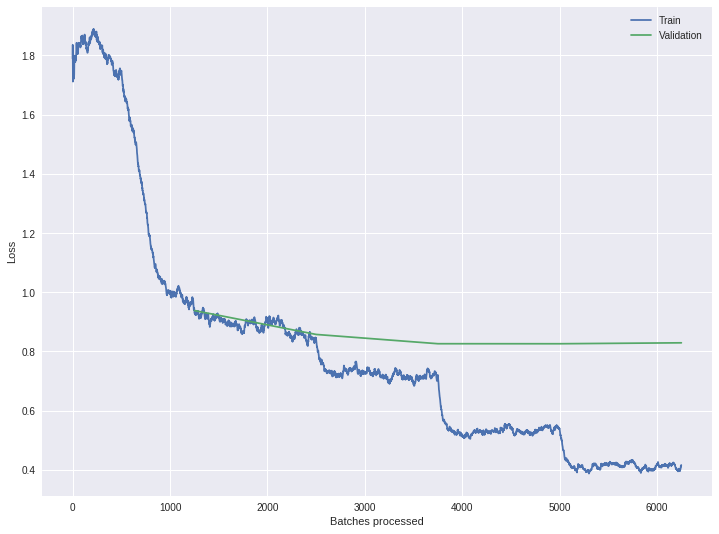

In [106]:
learn2.fit_one_cycle(5, 5e-3, moms=(0.95, 0.85))
learn2.recorder.plot_losses()

In [0]:
learn2_table = learn2.csv_logger.read_logged_file()

In [108]:
learn2_table

,epoch,train_loss,valid_loss
0,1,0.942422,0.937869
1,2,0.844139,0.857146
2,3,0.720331,0.825792
3,4,0.538179,0.825705
4,5,0.415496,0.828844


In [109]:
# Calculate RMSE from Mean-Squared Error

fai_train_rmse = np.sqrt(learn2_table.train_loss.values[-1])
fai_valid_rmse = np.sqrt(learn2_table.valid_loss.values[-1])

print("Training loss:", fai_train_rmse)
print("Validation loss", fai_valid_rmse)

Training loss: 0.6445897920383163
Validation loss 0.9104086994311951


These scores are all pretty good! They just barely beat the benchmarks from librec.net, but that's a good start. Let's try a grid search to see if we can improve them.

### Cross-Validation Sets

The fast.ai library lacks a dedicated grid search class, and also doesn't have cross-validation built in, so we're going to have to do this manually. 

By default, fastai's CollabDataBunch object does its own random splitting into "train" and "valid" according to the pct_val parameter. Since we want to load in our own pre-split segments to perform actual cross-validation, we can bypass the fastai train-test split by loading in our train set (one for each fold), setting pct_val to 0 so none of it is split into a train set, then using the optional "test" parameter to load in the data we want to use for validation.

We can then swap in the test_ds.x (test dataset) attribute for the valid_ds.x attribute, and just use our "rating" ground truth in list form as the valid_ds.y attribute. (N.B.: a list can be loaded in as the target variable, but independent variables yield an error when this is attempted.)

This method is a bit of a kludge, but it lets us evaluate our models using the same movie-user indices in k-fold cross-validation.

In [110]:
# CollabDataBunch A
data_a = CollabDataBunch.from_df(df_merged.iloc[train_index_a][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_a][['userId', 'movieId', 'rating']],
                                 pct_val=0)

data_a.valid_ds.x = data_a.test_ds.x
data_a.valid_ds.y = list(df_merged.iloc[test_index_a]['rating'])

# CollabDataBunch B
data_b = CollabDataBunch.from_df(df_merged.iloc[train_index_b][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_b][['userId', 'movieId', 'rating']],
                                 pct_val=0)

data_b.valid_ds.x = data_b.test_ds.x
data_b.valid_ds.y = list(df_merged.iloc[test_index_b]['rating'])

# CollabDataBunch C
data_c = CollabDataBunch.from_df(df_merged.iloc[train_index_c][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_c][['userId', 'movieId', 'rating']],
                                 pct_val=0)

data_c.valid_ds.x = data_c.test_ds.x
data_c.valid_ds.y = list(df_merged.iloc[test_index_c]['rating'])

# CollabDataBunch D
data_d = CollabDataBunch.from_df(df_merged.iloc[train_index_d][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_d][['userId', 'movieId', 'rating']],
                                 pct_val=0)

data_d.valid_ds.x = data_d.test_ds.x
data_d.valid_ds.y = list(df_merged.iloc[test_index_d]['rating'])

# CollabDataBunch E
data_e = CollabDataBunch.from_df(df_merged.iloc[train_index_e][['userId', 'movieId', 'rating']],
                                 test=df_merged.iloc[test_index_e][['userId', 'movieId', 'rating']],
                                 pct_val=0)

data_e.valid_ds.x = data_e.test_ds.x
data_e.valid_ds.y = list(df_merged.iloc[test_index_e]['rating'])

# Sample Batch for data_a:

data_a.show_batch()

y_range = [0, 5.5]

userId,movieId,target
727,197,3.0
472,790,3.0
416,1495,3.0
90,813,4.0
425,97,2.0


### Grid Search

The models with 30 and 45 latent factors performed marginally better than the model with 15 factors, so we'll include that as part of our parameter space for the grid search, along with slightly increased learning rate, and adjusted momentums.

In [0]:
parameter_space_fai = {'lr':[5e-3, 7e-3], 'moms':[(0.95, 0.85), (0.95, 0.7)],
                  'n_factors':[30, 45]}

databunches = [data_a, data_b, data_c, data_d, data_e]

In [0]:
try:
  fai_gridsearch = pd.read_csv('/content/drive/Colab Notebooks/ml-100k/fai_gridsearch.csv',
                        index_col=0)
except FileNotFoundError:
  
  #Create empty DataFrame to hold grid search data:
  fai_gridsearch = pd.DataFrame()
  
  #Create empty lists to be turned into DataFrame
  
  namelist_fai = []

  trainloss_a = []
  trainloss_b = []
  trainloss_c = []
  trainloss_d = []
  trainloss_e = []

  testloss_a = []
  testloss_b = []
  testloss_c = []
  testloss_d = []
  testloss_e = []
  
  for lr in parameter_space_fai['lr']:
    for moms in parameter_space_fai['moms']:
      for n_factors in parameter_space_fai['n_factors']:

        algoname = 'Fast.AI_lr:{}_moms:{}_n_factors:{}'.format(lr, moms, n_factors)
        namelist_fai.append(algoname)
        print(algoname)
        
        trainlosses = []
        testlosses = []

        for fold, data in zip(folds, databunches):
          print(fold)
          learn = collab_learner(data, n_factors=n_factors, y_range=y_range,
                                 wd=0.05, callback_fns=[CSVLogger])
          learn.fit_one_cycle(5, lr, moms=moms)

          learn_table = learn.csv_logger.read_logged_file()
          learn_table
          # Calculate RMSE from Mean-Squared Error

          fai_train_rmse = np.sqrt(learn_table.train_loss.values[-1])
          fai_valid_rmse = np.sqrt(learn_table.valid_loss.values[-1])

          trainlosses.append(fai_train_rmse)
          testlosses.append(fai_valid_rmse)
          
          print("Training loss (RMSE):", fai_train_rmse)
          print("Validation loss (RMSE)", fai_valid_rmse)
          
        trainloss_a.append(trainlosses[0])
        trainloss_b.append(trainlosses[1])
        trainloss_c.append(trainlosses[2])
        trainloss_d.append(trainlosses[3])
        trainloss_e.append(trainlosses[4])

        testloss_a.append(testlosses[0])
        testloss_b.append(testlosses[1])
        testloss_c.append(testlosses[2])
        testloss_d.append(testlosses[3])
        testloss_e.append(testlosses[4])
        
        
  fai_gridsearch['parameter_list'] = namelist_fai

  fai_gridsearch['trainloss_a'] = trainloss_a
  fai_gridsearch['trainloss_b'] = trainloss_b
  fai_gridsearch['trainloss_c'] = trainloss_c
  fai_gridsearch['trainloss_d'] = trainloss_d
  fai_gridsearch['trainloss_e'] = trainloss_e

  fai_gridsearch['testloss_a'] = testloss_a
  fai_gridsearch['testloss_b'] = testloss_b
  fai_gridsearch['testloss_c'] = testloss_c
  fai_gridsearch['testloss_d'] = testloss_d
  fai_gridsearch['testloss_e'] = testloss_e

  fai_gridsearch['mean_train_loss'] = fai_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].mean(axis=1)

  fai_gridsearch['mean_test_loss'] = fai_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].mean(axis=1)
  
  fai_gridsearch['train_loss_std'] = fai_gridsearch[['trainloss_a',
                                                      'trainloss_b',
                                                      'trainloss_c',
                                                      'trainloss_d',
                                                      'trainloss_e']].std(axis=1)
  
  fai_gridsearch['test_loss_std'] = fai_gridsearch[['testloss_a',
                                                   'testloss_b',
                                                   'testloss_c',
                                                   'testloss_d',
                                                   'testloss_e']].std(axis=1)

  fai_gridsearch.to_csv('/content/drive/Colab Notebooks/ml-100k/fai_gridsearch.csv')

In [113]:
# Results of fastai grid search:

fai_gridsearch

,parameter_list,trainloss_a,trainloss_b,trainloss_c,trainloss_d,trainloss_e,testloss_a,testloss_b,testloss_c,testloss_d,testloss_e,mean_train_loss,mean_test_loss,train_loss_std,test_loss_std
0,"Fast.AI_lr:0.005_moms:(0.95, 0.85)_n_factors:30",0.712867,0.719926,0.717462,0.735788,0.746560,0.903110,0.905409,0.905672,0.908856,0.907224,0.726521,0.906054,0.014137,0.002148
1,"Fast.AI_lr:0.005_moms:(0.95, 0.85)_n_factors:45",0.633014,0.633357,0.634490,0.645675,0.644965,0.911399,0.913450,0.915968,0.915870,0.913481,0.638300,0.914034,0.006436,0.001917
2,"Fast.AI_lr:0.005_moms:(0.95, 0.7)_n_factors:30",0.732896,0.731407,0.732636,0.736249,0.721913,0.900968,0.906567,0.908219,0.907770,0.905120,0.731020,0.905729,0.005398,0.002920
3,"Fast.AI_lr:0.005_moms:(0.95, 0.7)_n_factors:45",0.638512,0.665706,0.642994,0.651137,0.648861,0.911395,0.916829,0.916099,0.916509,0.914400,0.649442,0.915046,0.010353,0.002246
4,"Fast.AI_lr:0.007_moms:(0.95, 0.85)_n_factors:30",0.653818,0.671641,0.658095,0.644400,0.658919,0.913128,0.922148,0.918145,0.924735,0.918540,0.657375,0.919339,0.009841,0.004406
5,"Fast.AI_lr:0.007_moms:(0.95, 0.85)_n_factors:45",0.563495,0.580839,0.563732,0.562401,0.566101,0.928117,0.936867,0.931934,0.939412,0.933418,0.567314,0.933950,0.007680,0.004379
6,"Fast.AI_lr:0.007_moms:(0.95, 0.7)_n_factors:30",0.666524,0.652422,0.670448,0.663731,0.657659,0.916222,0.920352,0.919424,0.923782,0.917438,0.662157,0.919444,0.007164,0.002917
7,"Fast.AI_lr:0.007_moms:(0.95, 0.7)_n_factors:45",0.570048,0.579558,0.568169,0.553214,0.569402,0.926436,0.929704,0.937579,0.935396,0.932944,0.568078,0.932412,0.009465,0.004442


In [114]:
fai_gridsearch[fai_gridsearch['mean_test_loss'] == fai_gridsearch['mean_test_loss'].min()]

,parameter_list,trainloss_a,trainloss_b,trainloss_c,trainloss_d,trainloss_e,testloss_a,testloss_b,testloss_c,testloss_d,testloss_e,mean_train_loss,mean_test_loss,train_loss_std,test_loss_std
2,"Fast.AI_lr:0.005_moms:(0.95, 0.7)_n_factors:30",0.732896,0.731407,0.732636,0.736249,0.721913,0.900968,0.906567,0.908219,0.90777,0.90512,0.73102,0.905729,0.005398,0.00292


This is only slightly lower than the benchmark, but it *is* better.

## Keras

### Matrix Factorization

In [0]:
train, test = train_test_split(df_merged[['userId', 'movieId', 'rating']],
                               test_size=0.2, random_state=0)

In [116]:
train.head()

,userId,movieId,rating
10382,647,237,3.0
73171,318,326,4.0
30938,903,211,5.0
99310,450,1271,2.0
58959,379,517,4.0


In [117]:
n_users = len(df_merged.userId.unique())
n_movies = len(df_merged.movieId.unique())

print(n_users, n_movies)

943 1682


#### 30 Factors, SGD Optimizer modeled after fast.ai parameters

In an attempt to compare fast.ai's collab_learner to Keras' some-assmebly-required models, we'll start by using the same values as we did for our fast.ai model: a stochastic gradient descent optimizer, 0.005 learning rate, 0.95 momentum (Keras' momentum doesn't take a tuple, but ideally we'd have this dip to 0.7), a weight decay of 0.05, and a batch size of 64 (default for both modules).

In [0]:
n_latent_factors = 30

In [0]:
optimizer = keras.optimizers.SGD(lr=0.005, momentum=0.95,
                                 decay=0.05, nesterov=False)

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1,
                         n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1,
                         n_latent_factors, name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=-1)
collab_filter_model = keras.Model([user_input, movie_input], prod)
collab_filter_model.compile(optimizer=optimizer, loss='mean_squared_error')

In [0]:
SVG(model_to_dot(collab_filter_model,  show_shapes=True,
          show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

keras.utils.plot_model(collab_filter_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model1.png')

In [121]:
collab_filter_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 30)        50490       Movie[0][0]                      
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 30)        28320       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [122]:
collab_filter_history = collab_filter_model.fit([train.userId, train.movieId],
                          train.rating, epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 8s 101us/step - loss: 13.7084
Epoch 2/25
80000/80000 [==============================] - 8s 99us/step - loss: 13.7081
Epoch 3/25
80000/80000 [==============================] - 8s 99us/step - loss: 13.7081
Epoch 4/25
80000/80000 [==============================] - 8s 100us/step - loss: 13.7080
Epoch 5/25
80000/80000 [==============================] - 8s 99us/step - loss: 13.7080
Epoch 6/25
80000/80000 [==============================] - 8s 98us/step - loss: 13.7080
Epoch 7/25
80000/80000 [==============================] - 8s 100us/step - loss: 13.7080
Epoch 8/25
80000/80000 [==============================] - 8s 100us/step - loss: 13.7080
Epoch 9/25
80000/80000 [==============================] - 8s 100us/step - loss: 13.7080
Epoch 10/25
80000/80000 [==============================] - 8s 99us/step - loss: 13.7080
Epoch 11/25
80000/80000 [==============================] - 8s 98us/step - loss: 13.7079
Epoch 12/25
80000/80000 [===========

In [123]:
y_pred = collab_filter_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(collab_filter_model.predict([test.userId, test.movieId]), 0)
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

3.715108637869368
3.715063929463395


This is remarkably poor. The same parameters that worked well in the fast.ai model barely have any loss reduction during training, even after five times the number of epochs.. There is clearly more at work here than these parameters.

Let's try the default settings for the Adam optimizer instead of SGD with the fast.ai settings.

#### 30 Factors, Adam Optimizer, default parameters

In [0]:
n_latent_factors = 30

In [0]:
# 'adam' has a default learning rate of 0.001 and a default weight decay of 0.0.

movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1,
                         n_latent_factors, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1,
                         n_latent_factors, name='User-Embedding')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=-1)
collab_filter_model2 = keras.Model([user_input, movie_input], prod)
collab_filter_model2.compile(optimizer='adam', loss='mean_squared_error')

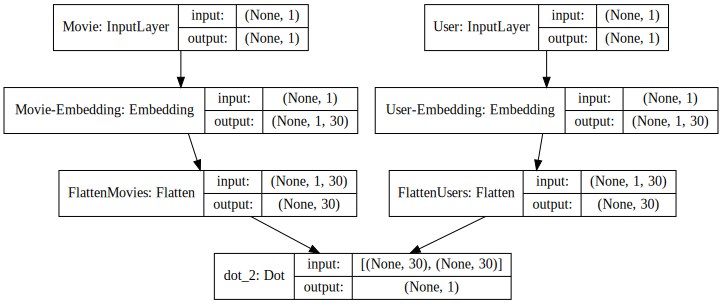

In [126]:
SVG(model_to_dot(collab_filter_model2,  show_shapes=True,
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

In [127]:
collab_filter_model2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 30)        50490       Movie[0][0]                      
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 30)        28320       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [128]:
collab_filter_history2 = collab_filter_model2.fit([train.userId, train.movieId],
                          train.rating, epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 9s 112us/step - loss: 7.6948
Epoch 2/25
80000/80000 [==============================] - 9s 109us/step - loss: 1.2040
Epoch 3/25
80000/80000 [==============================] - 9s 110us/step - loss: 0.9546
Epoch 4/25
80000/80000 [==============================] - 9s 110us/step - loss: 0.9075
Epoch 5/25
80000/80000 [==============================] - 9s 110us/step - loss: 0.8822
Epoch 6/25
80000/80000 [==============================] - 9s 108us/step - loss: 0.8530
Epoch 7/25
80000/80000 [==============================] - 9s 110us/step - loss: 0.8215
Epoch 8/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.7878
Epoch 9/25
80000/80000 [==============================] - 9s 110us/step - loss: 0.7508
Epoch 10/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.7127
Epoch 11/25
80000/80000 [==============================] - 9s 109us/step - loss: 0.6728
Epoch 12/25
80000/80000 [================

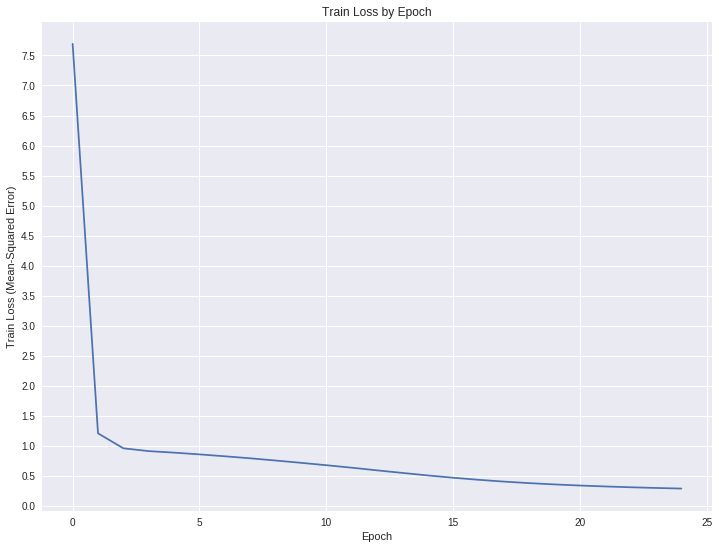

In [129]:
plt.rcParams['figure.figsize'] = 12, 9

plt.title('Train Loss by Epoch')

pd.Series(collab_filter_history2.history['loss']).plot()
plt.yticks(np.arange(0, 8, 0.5))
plt.xlabel('Epoch')
plt.ylabel('Train Loss (Mean-Squared Error)')
plt.show()

In [130]:
y_pred = collab_filter_model2.predict([test.userId, test.movieId])
y_pred_rounded = np.round(collab_filter_model2.predict([test.userId, test.movieId]), 0)
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

1.0571547826691448
1.0959470790143109


This is approaching where we should be, but it's still disapponting.

#### 30 Factors, Added Bias Terms

Bias terms (as described by Jeremy Howard in the fast.ai lecutres on collaborative filtering) are additional weights that accompany the latent factors, but which are not included in the dot product. These can help account for things like a user being stingier with their rating scores than other users, or a movie just being a better movie than others in the dataset.

Each user and each movie gets a bias term (as part of a bias layer). We'll see if this has an impact on our Keras model.

In [0]:
n_latent_factors = 30

In [0]:
movie_input = keras.layers.Input(shape=[1],name='Movie')
movie_embedding = keras.layers.Embedding(n_movies + 1,
                         n_latent_factors, name='Movie-Embedding')(movie_input)
movie_bias = keras.layers.Embedding(n_movies+1, output_dim=1, name='Movie-Bias')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User')
user_embedding = keras.layers.Embedding(n_users + 1,
                         n_latent_factors, name='User-Embedding')(user_input)
user_bias = keras.layers.Embedding(n_users+1, output_dim=1, name='User-Bias')(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=-1)
prod = keras.layers.add(inputs=[prod, movie_bias, user_bias])
prod = keras.layers.Flatten()(prod)
collab_bias_model = keras.Model([user_input, movie_input], prod)
collab_bias_model.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
SVG(model_to_dot(collab_bias_model,  show_shapes=True,
                 show_layer_names=True, rankdir='TB').create(prog='dot', format='svg'))

keras.utils.plot_model(collab_bias_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model2.png')


In [134]:
collab_bias_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Movie (InputLayer)              (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 30)        50490       Movie[0][0]                      
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 30)        28320       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [135]:
collab_bias_history = collab_bias_model.fit([train.userId, train.movieId],
                          train.rating, epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 11s 142us/step - loss: 6.9773
Epoch 2/25
80000/80000 [==============================] - 11s 140us/step - loss: 1.1273
Epoch 3/25
80000/80000 [==============================] - 11s 136us/step - loss: 0.9195
Epoch 4/25
80000/80000 [==============================] - 11s 135us/step - loss: 0.8636
Epoch 5/25
80000/80000 [==============================] - 11s 135us/step - loss: 0.8201
Epoch 6/25
80000/80000 [==============================] - 11s 136us/step - loss: 0.7834
Epoch 7/25
80000/80000 [==============================] - 11s 135us/step - loss: 0.7457
Epoch 8/25
80000/80000 [==============================] - 11s 135us/step - loss: 0.7070
Epoch 9/25
80000/80000 [==============================] - 11s 135us/step - loss: 0.6673
Epoch 10/25
80000/80000 [==============================] - 11s 136us/step - loss: 0.6281
Epoch 11/25
80000/80000 [==============================] - 11s 136us/step - loss: 0.5887
Epoch 12/25
80000/80000 [=====

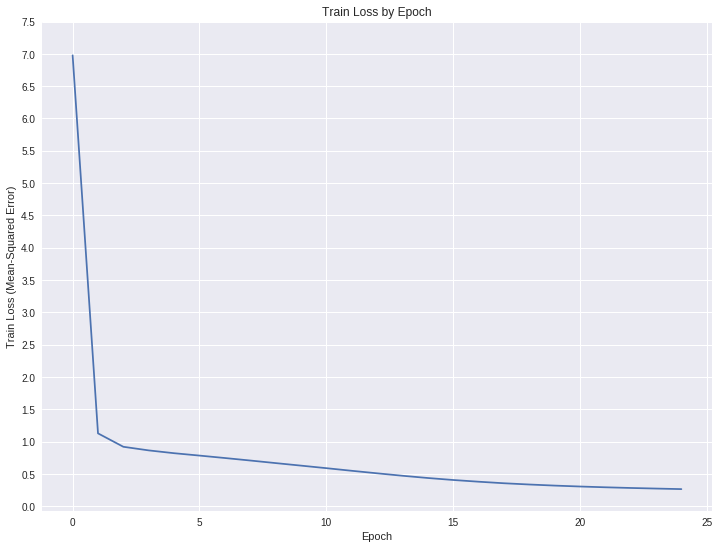

In [136]:
plt.rcParams['figure.figsize'] = 12, 9

plt.title('Train Loss by Epoch')

pd.Series(collab_bias_history.history['loss']).plot()
plt.yticks(np.arange(0, 8, 0.5))
plt.xlabel('Epoch')
plt.ylabel('Train Loss (Mean-Squared Error)')
plt.show()

In [137]:
y_pred = collab_bias_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(collab_bias_model.predict([test.userId, test.movieId]), 0)
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

1.069006608484368
1.1058933040759402


Adding bias terms for movies and users didn't seem to have much of an effect on the loss. We're going to try one last Keras model, this time using a deep neural net based on Nipun Batra's model for collaborative filtering (see Sources).

### Deep Neural Network

In [0]:
n_latent_factors_user = 15
n_latent_factors_movie = 15

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie,
                                         name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.1)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1,
                                    n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.1)(user_vec)


concat = keras.layers.merge.concatenate([movie_vec, user_vec], axis=-1)
concat_dropout = keras.layers.Dropout(0.1)(concat)
dense = keras.layers.Dense(600,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.1,name='Dropout')(dense)
dense_2 = keras.layers.Dense(300,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.1,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(60,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.1,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(30,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
dnn_model = keras.Model([user_input, movie_input], result)
dnn_model.compile(optimizer='adam', loss= 'mean_squared_error')

In [0]:
SVG(model_to_dot(dnn_model, show_shapes=True, show_layer_names=True,
                 rankdir='HB').create(prog='dot', format='svg'))

keras.utils.plot_model(dnn_model,
              to_file='/content/drive/Colab Notebooks/ml-100k/keras_model3.png')

In [140]:
dnn_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 15)        25245       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 15)        14160       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [141]:
dnn_history = dnn_model.fit([train.userId, train.movieId], train.rating, epochs=25, verbose=1)

Epoch 1/25
80000/80000 [==============================] - 14s 181us/step - loss: 1.0715
Epoch 2/25
80000/80000 [==============================] - 14s 172us/step - loss: 0.9168
Epoch 3/25
80000/80000 [==============================] - 14s 177us/step - loss: 0.9060
Epoch 4/25
80000/80000 [==============================] - 14s 174us/step - loss: 0.8944
Epoch 5/25
80000/80000 [==============================] - 14s 172us/step - loss: 0.8887
Epoch 6/25
80000/80000 [==============================] - 14s 172us/step - loss: 0.8847
Epoch 7/25
80000/80000 [==============================] - 14s 172us/step - loss: 0.8800
Epoch 8/25
80000/80000 [==============================] - 14s 172us/step - loss: 0.8699
Epoch 9/25
80000/80000 [==============================] - 14s 171us/step - loss: 0.8536
Epoch 10/25
80000/80000 [==============================] - 14s 173us/step - loss: 0.8435
Epoch 11/25
80000/80000 [==============================] - 14s 173us/step - loss: 0.8297
Epoch 12/25
80000/80000 [=====

In [142]:
y_pred = dnn_model.predict([test.userId, test.movieId])
y_pred_rounded = np.round(dnn_model.predict([test.userId, test.movieId]))
y_true = test.rating

print(np.sqrt(mse(y_true, y_pred)))
print(np.sqrt(mse(y_true, y_pred_rounded)))

0.9238365193911174
0.96850400102426


These scores look much better than the other Keras model's scores! However, the loss is still higher than the librec benchmark.

# Conclusion

The fastai library had the best performance for the amount of effort required to use it, but none of the matrix factorization methods outperformed random forest regression on engineered features. We achieved our lowest cross-validated error score of 0.717 with a random forest regression with 150 estimators.

This model is somewhat computationally expensive, but the result is significantly lower than the librec.net benchmark of 0.911, and the next lowest error score we were able to achieve (fast.ai with a learning rate of 0.005, momentums of 0.95 and 0.7, and 30 latent factors) achieved a score barely lower than the benchmark, 0.906.

Problems with more limited available data might be better solved through use of neural net models, but given the categorical information included in the MovieLens 100k dataset, we were better off implementing a model that could take advantage of those preexisting categories.

# Implementation/Expandability

Using the random forest model, it is a fairly simple matter to take a subset of those movies with the highest-predicted ratings and to recommend that subset to the user. Although we rounded the scores to determine the loss for our models, we could use unrounded regression scores to determine predicted ranking with more granularity.

Assuming this algorithm is going to be implemented for a movie streaming service, we could also gather implicit rating information from a combination of user behavior, such as whether a user watched the entirety of a movie or just the first few minutes, or whether a user watched the movie more than once.

To solve the aforementioned "cold start" problem, there are a number of approaches that may work. For new users, it would be possible to have them complete a short survey about movies they had seen and liked in order to jump-start the process of recommendation. When providing the list of recommended movies to a user, it would also be possible to seed the list of recommendations with movies that have few ratings, in hopes of obtaining more information about those movies.

The random forest model would likely be better at the outset, but continuing to maintain it by recomputing mean ratings, genre proprotions, etc. each time a user watches another movie, would likely prove difficult. As user base and movie catalog grow, it would become more computationally complex to compute these values, and it might be better to use either a random sample of the data to compute them, or to switch to a neural net model.

# Sources


MovieLens 100k dataset:

https://grouplens.org/datasets/movielens/


MovieLens 100k dataset on Kaggle:

https://www.kaggle.com/prajitdatta/movielens-100k-dataset


Prince Grover's article on collaborative filtering methods, covering memory-based and model-based approaches:

https://towardsdatascience.com/various-implementations-of-collaborative-filtering-100385c6dfe0


fast.ai lessons on collaborative filtering, with matrix factorization in Microsoft Excel:

https://course.fast.ai/videos/?lesson=4

https://course.fast.ai/videos/?lesson=5


Nipun Batra's Keras models (shallow and deep neural networks):

https://nipunbatra.github.io/blog/2017/recommend-keras.html


Will Wolf's Keras models (adding a bias term to CF):

http://willwolf.io/2017/04/07/approximating-implicit-matrix-factorization-with-shallow-neural-networks/


MAE vs. RMSE as loss function:

https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d


JJ Espinoza on how collaborative filtering is used in the entertainment industry (tailored movie trailers!):

https://twimlai.com/twiml-talk-220-building-a-recommender-system-from-scratch-at-20th-century-fox-with-jj-espinoza/


Vishakha Lall on the basics of Google Colab:

https://medium.com/lean-in-women-in-tech-india/google-colab-the-beginners-guide-5ad3b417dfa


